In [1]:
import pandas as pd
import numpy as np
import joblib

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import load_model
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
import pickle
import math
import gc
from collections import defaultdict
from scipy.stats import zscore

In [18]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def convert_to_pairwise_train(X_train, y_train):
    pairs = []
    labels = []
    ids = []
    n_samples = X_train.shape[0]
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            pairs.append([X_train[i, 2:], X_train[j, 2:]])
            ids.append([X_train[i, :2], X_train[j, :2]])
            labels.append(1 if y_train[i] > y_train[j] else 0)
    return np.array(pairs).astype('float32'), np.array(labels).astype('float32'), np.array(ids)

def convert_to_pairwise_test(X_test):
    pairs = []
    ids = []
    n_samples = X_test.shape[0]
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            pairs.append([X_test[i, 2:], X_test[j, 2:]])
            ids.append([X_test[i, :2], X_test[j, :2]])
    return np.array(pairs).astype('float32'), np.array(ids)


def pairwise_generator(X, y, batch_size):
    n_samples = X.shape[0]

    while True:
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_X = X[start:end]
            batch_y = y[start:end]

            X_batch = []
            y_batch = []
            for i in range(len(batch_X)):
                date_i = batch_X[i, 0]
                for j in range(i+1, len(batch_X)):
                    date_j = batch_X[j, 0]
                    if date_i == date_j:
                        X_pair = [batch_X[i, 2:], batch_X[j, 2:]]
                        X_batch.append(X_pair)
                        y_batch.append(1 if batch_y[i] > batch_y[j] else 0)
                        X_id_pair = [batch_X[i, :2], batch_X[j, :2]]

            yield np.array(X_batch), np.array(y_batch)


def pairwise_generator_ids(X, y, batch_size):
    n_samples = X.shape[0]

    while True:
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_X = X[start:end]
            batch_y = y[start:end]

            X_batch = []
            X_ids_batch = []
            y_batch = []
            for i in range(len(batch_X)):
                date_i = batch_X[i, 0]
                for j in range(i+1, len(batch_X)):
                    date_j = batch_X[j, 0]
                    if date_i == date_j:
                        X_pair = [batch_X[i, 2:], batch_X[j, 2:]]
                        X_batch.append(X_pair)
                        y_batch.append(1 if batch_y[i, 2] > batch_y[j, 2] else 0)
                        X_id_pair = [batch_X[i, :2], batch_X[j, :2]]
                        X_ids_batch.append(X_id_pair)

            yield np.array(X_batch), np.array(X_ids_batch), np.array(y_batch)


def pairwise_generator2(X, y, batch_size):
    n_samples = X.shape[0]

    while True:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)  # Shuffle indices to create random batches
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_indices = indices[start:end]
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]

            X_batch = []
            y_batch = []
            for i in range(len(batch_X)):
                date_i = batch_X[i, 0]
                same_date_indices = [j for j in range(i+1, len(batch_X)) if batch_X[j, 0] == date_i]
                for j in same_date_indices:
                    X_pair = [batch_X[i, 2:], batch_X[j, 2:]]  # Pairs are now complete rows
                    X_batch.append(X_pair)
                    y_batch.append(1 if batch_y[i, 2] > batch_y[j, 2] else 0)

            yield np.array(X_batch, dtype='float32'), np.array(y_batch, dtype='float32')


def pairwise_generator3(X, y, batch_size):
    n_samples = X.shape[0]
    generated_pairs = set()  # To store generated pairs and avoid duplicates

    while True:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)  # Shuffle indices to create random batches
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_indices = indices[start:end]
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]

            X_batch = []
            y_batch = []
            for i in range(len(batch_X)):
                date_i = batch_X[i, 0]
                same_date_indices = [j for j in range(i+1, len(batch_X)) if batch_X[j, 0] == date_i]
                for j in same_date_indices:
                    pair_key = tuple(sorted((i, j)))  # Create a unique key for the pair
                    if pair_key not in generated_pairs:  # Check if pair is already generated
                        X_pair = [batch_X[i, 2:], batch_X[j, 2:]]
                        y_pair = 1 if batch_y[i, 2] > batch_y[j, 2] else 0
                        X_batch.append(X_pair)
                        y_batch.append(y_pair)
                        generated_pairs.add(pair_key)

            yield np.array(X_batch, dtype='float32'), np.array(y_batch, dtype='float32')


def pairwise_generator4(X, y, batch_size):
    n_samples = X.shape[0]
    generated_pairs = set()  # To store generated pairs and avoid duplicates

    while True:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)  # Shuffle indices to create random batches
        batch_X = X[indices]
        batch_y = y[indices]

        X_batch = []
        y_batch = []
        X_batch_ids = []

        for i in range(n_samples):
            date_i = batch_X[i, 0]
            same_date_indices = [j for j in range(i+1, n_samples) if batch_X[j, 0] == date_i]
            for j in same_date_indices:
                pair_key = tuple(sorted((i, j)))  # Create a unique key for the pair
                if pair_key not in generated_pairs:  # Check if pair is already generated
                    X_pair = [batch_X[i, 2:], batch_X[j, 2:]]
                    X_pair_ids = [batch_X[i, :2], batch_X[j, :2]]
                    y_pair = 1 if batch_y[i, 2] > batch_y[j, 2] else 0
                    X_batch.append(X_pair)
                    X_batch_ids.append(X_batch_ids)
                    y_batch.append(y_pair)
                    generated_pairs.add(pair_key)

                    if len(X_batch) == batch_size:
                        yield np.array(X_batch, dtype='float32'), np.array(y_batch, dtype='float32'), np.array(X_batch_ids)
                        X_batch = []
                        y_batch = []
                        X_batch_ids = []


def pairwise_combinations_with_ids_and_values(X):
    n_samples = X.shape[0]
    generated_pairs = set()  # To store generated pairs and avoid duplicates
    X_pairs = []
    X_pair_ids = []

    for i in range(n_samples):
        date_i = X[i, 0]
        same_date_indices = [j for j in range(i + 1, n_samples) if X[j, 0] == date_i]
        for j in same_date_indices:
            pair_key = tuple(sorted((i, j)))  # Create a unique key for the pair
            if pair_key not in generated_pairs:  # Check if pair is already generated
                X_pair = np.array([X[i, 2:], X[j, 2:]])
                X_pair_id = np.array([X[i, :2], X[j, :2]])
                generated_pairs.add(pair_key)
                X_pairs.append(X_pair)
                X_pair_ids.append(X_pair_id)

    return np.array(X_pairs, dtype='float32'), np.array(X_pair_ids)




def pairwise_generator5(X, y, batch_size):
    n_samples = X.shape[0]
    generated_pairs = set()  # To store generated pairs and avoid duplicates

    while True:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)  # Shuffle indices to create random batches
        batch_X = X[indices]
        batch_y = y[indices]

        X_batch = []
        y_batch = []

        # Create a dictionary to store indices for each date
        date_indices = defaultdict(list)
        for i in range(n_samples):
            date_indices[batch_X[i, 0]].append(i)

        for i in range(n_samples):
            date_i = batch_X[i, 0]
            same_date_indices = date_indices[date_i]
            for j in same_date_indices:
                if i >= j:
                    continue
                pair_key = (i, j)  # Use indices directly as a unique key
                if pair_key not in generated_pairs:  # Check if pair is already generated
                    X_pair = np.array([batch_X[i, 2:], batch_X[j, 2:]])
                    y_pair = 1 if batch_y[i, 2] > batch_y[j, 2] else 0
                    X_batch.append(X_pair)
                    y_batch.append(y_pair)
                    generated_pairs.add(pair_key)

                    if len(X_batch) == batch_size:
                        yield np.array(X_batch, dtype='float32'), np.array(y_batch, dtype='float32').reshape(-1,1)
                        X_batch = []
                        y_batch = []

In [19]:
### TRAIN METHODOLOGY 2 ###
def train(X_train: pd.DataFrame, y_train: pd.DataFrame, model_directory_path: str = "../resources") -> None:
    max_date = X_train['date'].max()
    min_date = 150
    X_train_orig = X_train[(X_train['date'] < max_date) & (X_train['date'] > min_date)]
    X_test = X_train[X_train['date'] == max_date]
    y_train_orig = y_train[(y_train['date'] < max_date) & (y_train['date'] > min_date)]
    y_test = y_train[y_train['date'] == max_date]

    #Scaling
    scaler = StandardScaler()
    X_ids = np.asarray(X_train_orig[['date', 'id']])
    X_scale_pca = X_train_orig.drop(columns=['date', 'id'])
    X_scale_pca = scaler.fit_transform(X_scale_pca)


    X_test_ids = np.asarray(X_test[['date', 'id']])
    X_test_scale_pca = X_test.drop(columns=['date', 'id'])
    X_test_scale_pca = scaler.transform(X_test_scale_pca)

    #PCA
    n_components = 40
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(X_scale_pca)
    X_train_concat = np.concatenate((X_ids, pca_features), axis=1)
    y_train = np.asarray(y_train)

    pca_features_test = pca.transform(X_test_scale_pca)
    X_test_concat = np.concatenate((X_test_ids, pca_features_test), axis=1)
    y_test = np.asarray(y_test)


    #Save out Scaler and PCA
    with open(Path(model_directory_path) / 'scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)

    with open(Path(model_directory_path) / 'pca.pkl', 'wb') as file:
        pickle.dump(pca, file)

    date_list = list(set(X_train_orig['date']))

    batch_size = 500
    train_generator = pairwise_generator5(X_train_concat, y_train, batch_size)
    test_generator= pairwise_generator5(X_test_concat, y_test, batch_size)

    print(X_train_concat.shape)


    #Model Training
    model_pathname = Path('../resources') / "model.keras"

    if model_pathname.is_file():
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=20,
            verbose=0,
            mode='auto',
            baseline=None)

        history = model.fit(
            train_generator,
            batch_size=batch_size,
            steps_per_epoch = 1000,
            epochs=30,
            validation_data=test_generator,
            validation_steps = 500,
            callbacks=[mc, early_stopping],
            shuffle=True,
            use_multiprocessing=False,
            verbose=1
        )

    else:
        #Neural Network Model
        mc = ModelCheckpoint(model_pathname, monitor='val_loss', mode='min', verbose=1, save_best_only=False)

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=20,
            verbose=1,
            mode='auto',
            baseline=None)

        model = keras.Sequential([
            keras.layers.Dense(200, activation='relu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(2, (X_train_concat.shape[1] - 2))),
            #keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.5),  # Adding dropout regularization
            keras.layers.Dense(100, activation='relu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
            #keras.layers.BatchNormalization(),
            # keras.layers.Dropout(0.5),  # Adding dropout regularization
            # keras.layers.Dense(250, activation='relu', kernel_initializer='lecun_normal'),
            # keras.layers.BatchNormalization(),
            # keras.layers.Dropout(0.5),  # Adding dropout regularization
            # keras.layers.Dense(100, activation='relu', kernel_initializer='lecun_normal'),
            # keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.5),  # Adding dropout regularization
            keras.layers.Dense(25, activation='relu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
            keras.layers.Dropout(0.5),  # Adding dropout regularization,
            keras.layers.Flatten(),
            keras.layers.Dense(1, activation='sigmoid', kernel_initializer='lecun_normal')
        ])

        optimizer = keras.optimizers.Adam(learning_rate=3e-4)

        model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            train_generator,
            batch_size=batch_size,
            steps_per_epoch=1000,
            epochs=30,
            validation_data=test_generator,
            validation_steps=500,
            callbacks=[mc, early_stopping],
            shuffle=True,
            use_multiprocessing=False,
            verbose=1
        )

        model.save(model_pathname)




    gc.collect()

    print("Finished All Training")

    # make sure that the train function correctly save the trained model
    # in the model_directory_path
    # print(f"Saving model in {model_pathname}")
    # joblib.dump(model, model_pathname)

In [20]:
def infer(X_test: pd.DataFrame, model_directory_path: str = "../resources") -> pd.DataFrame:
    X_test_orig = X_test.copy()

    # Load Scaler
    with open(Path(model_directory_path) / 'scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Load PCA
    with open(Path(model_directory_path) / 'pca.pkl', 'rb') as file:
        pca = pickle.load(file)

    # Scaling
    X_ids = np.asarray(X_test_orig[['date', 'id']])
    X_scale_pca = X_test_orig.drop(columns=['date', 'id'])
    X_scale_pca = scaler.transform(X_scale_pca)

    # PCA
    pca_features = pca.transform(X_scale_pca)
    X_test_concat = np.concatenate((X_ids, pca_features), axis=1)


    result_df = pd.DataFrame(columns=['date', 'id', 'value'])

    # Load Model
    model_pathname = Path(model_directory_path) / "model.keras"
    model = load_model(model_pathname)

    # Pairwise Transformation using the pairwise generator
    batch_size = 1000
    X_test, X_test_ids = pairwise_combinations_with_ids_and_values(X_test_concat)

    print("Predicting for Test Data")
    preds = model.predict(X_test)

    preds_df = pd.DataFrame({'id': X_test_ids[:, 0, 1].flatten(), 'date': X_test_ids[:, 0, 0].flatten(), 'value': preds.flatten()})
    preds_df = preds_df.groupby(['date', 'id']).mean().reset_index()

    result_df = pd.merge(X_test_orig, preds_df, on=['id', 'date'], how='left')
    result_df['value'] = result_df['value'].fillna(result_df['value'].mean())

    minmax = MinMaxScaler(feature_range=(-1, 1))
    result_df['value'] = minmax.fit_transform(result_df[['value']])

    print("Finished predicting Test Data")

    return result_df

In [21]:
X_train = pd.read_parquet('../data/X_train.parquet')
y_train = pd.read_parquet('../data/y_train.parquet')
X_test = pd.read_parquet('../data/X_test.parquet')

In [23]:
train(X_train, y_train)

(415591, 42)
Epoch 1/30
 986/1000 [============================>.] - ETA: 0s - loss: 2.0753 - accuracy: 0.5146
Epoch 1: saving model to ..\resources\model.keras
1000/1000 [==============================] - 5s 5ms/step - loss: 2.0606 - accuracy: 0.5124 - val_loss: 1.0052 - val_accuracy: 0.5197
Epoch 2/30
 996/1000 [============================>.] - ETA: 0s - loss: 0.8060 - accuracy: 0.5351
Epoch 2: saving model to ..\resources\model.keras
1000/1000 [==============================] - 4s 4ms/step - loss: 0.8058 - accuracy: 0.5347 - val_loss: 0.7332 - val_accuracy: 0.4682
Epoch 3/30
 996/1000 [============================>.] - ETA: 0s - loss: 0.7054 - accuracy: 0.5124
Epoch 3: saving model to ..\resources\model.keras
1000/1000 [==============================] - 5s 5ms/step - loss: 0.7053 - accuracy: 0.5136 - val_loss: 0.6950 - val_accuracy: 0.5242
Epoch 4/30
 995/1000 [============================>.] - ETA: 0s - loss: 0.6951 - accuracy: 0.4882
Epoch 4: saving model to ..\resources\model.ke

In [24]:
model = load_model('../resources/model.keras')
val_loss, val_accuracy = model.evaluate(
    pairwise_generator5(X_train, y_train, 500),
    steps=1000
)

KeyError: "None of [Int64Index([440574,  35448,  81110, 190543, 137985, 699978, 389398, 491170,\n            478644, 221578,\n            ...\n            582616,  38200, 222407,     76, 685371, 434071, 181000, 680980,\n            326517, 278034],\n           dtype='int64', length=742670)] are in the [columns]"

In [25]:
X_test = X_train[X_train['date'] == 200].iloc[:100]
y_test = y_train[y_train['date'] == 200].iloc[:100]

In [7]:
X_train[X_train['date'] == 0]

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [27]:
test = infer(X_test)

Predicting for Test Data
155/155 [==============================] - 0s 2ms/step
Finished predicting Test Data


In [28]:
test

,date,id,0,1,2,3,4,5,6,7,...,452,453,454,455,456,457,458,459,460,value
0,200,b2014a4eb6f5be0b43de60668d6cda68f481fd1a3554de...,-0.395584,0.467767,0.334684,-0.003670,-0.084305,-0.610649,-1.911305,1.869958,...,0.064613,0.063679,-0.942424,0.437068,0.162571,-0.511908,0.700700,0.531277,0.554467,-1.0
1,200,77a12377576612a9a90570b270df5e6fe86f20fd8bacfb...,1.560541,-0.345553,0.395517,0.538143,0.061281,-0.426155,-0.099393,0.442215,...,-1.091513,-0.949481,0.495675,0.373371,-0.370041,1.043447,-0.436087,-1.206550,0.870037,-1.0
2,200,f0cce9977234a16b9171182664a0ef16f2fa373eb4b8c1...,-0.004308,1.535068,-0.351770,-0.574043,-0.736015,-0.483100,1.136352,0.610554,...,0.613645,-0.076734,0.458068,-1.385604,-1.153192,2.216623,1.369278,-0.214589,1.349027,-1.0
3,200,15e3163819739dc4b9318670fbda0c7361b25dc31b3025...,1.032348,-0.108589,0.112654,-0.984792,0.000401,-0.497814,0.447101,-0.370030,...,-0.917909,0.796511,-1.143900,-0.840966,-1.124376,-0.075706,0.875465,-0.645114,0.108495,-1.0
4,200,b61439cc04e2a6666b7b3834124952b00742885c74b4a3...,0.764759,-0.020000,-0.174101,0.250532,-0.470467,1.320027,0.844867,-0.067772,...,-1.779329,-0.287168,1.196917,0.474941,0.009121,-0.285514,-1.211052,3.517855,-1.681823,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,200,5f6c6e9cc1e1aba9aab4fbd4489c1978d5cf281c971b26...,0.946306,0.174979,0.472097,-0.425053,0.203503,2.093819,0.157956,0.368474,...,-0.056957,-0.243457,-0.240920,0.580476,-0.585203,0.696882,-0.258386,1.064468,0.977430,-1.0
96,200,1731cf53cff346ed7e47430dee7a317294db7b7387d5d4...,0.940856,0.458419,0.573755,0.127610,-0.120156,0.349935,1.293528,0.145554,...,0.064852,0.439111,1.256536,-1.425672,-0.791057,0.558181,0.024659,-0.445847,1.158122,-1.0
97,200,0c8977414e7c002bd97bc1ac870155bedf845a291e096b...,-0.909378,-0.389497,-1.426744,0.497973,-0.383100,1.234804,0.322476,0.101190,...,-1.074217,-0.510769,-1.025943,0.338949,0.143359,-1.936703,0.057343,-0.419597,-0.998607,-1.0
98,200,002a1309181f9e7e2eb0557c4dca257d4197be58981b2a...,-0.812412,-0.683046,-1.333758,0.900040,0.318777,1.192798,0.447456,0.103943,...,-1.128484,-0.906456,1.199849,-0.729728,0.334035,0.411012,0.341870,0.655641,0.402195,-1.0


array([[-0.66758526, -0.81911179, -0.07204253, -0.02755289],
       [ 1.05854155, -0.69364701, -0.12870892,  1.82694012],
       [ 0.70995108, -0.42835449,  1.09309793, -0.22740316],
       [ 0.5274588 ,  1.91407711,  0.854834  , -0.3534117 ],
       [-1.62836617,  0.02703618, -1.74718048, -1.21857237]])

# TESTING

In [10]:
X_train = pd.read_parquet('../data/X_train.parquet')
y_train = pd.read_parquet('../data/y_train.parquet')
X_test = pd.read_parquet('../data/X_test.parquet')

In [11]:
max_date = X_train['date'].max()
model_directory_path = '../resources'
min_date = 150
X_train_orig = X_train[(X_train['date'] < max_date) & (X_train['date'] > min_date)]
X_test = X_train[X_train['date'] == max_date]
y_train_orig = y_train[(y_train['date'] < max_date) & (y_train['date'] > min_date)]
y_test = y_train[y_train['date'] == max_date]

#Scaling
scaler = StandardScaler()
X_ids = np.asarray(X_train_orig[['date', 'id']])
X_scale_pca = X_train_orig.drop(columns=['date', 'id'])
X_scale_pca = scaler.fit_transform(X_scale_pca)


X_test_ids = np.asarray(X_test[['date', 'id']])
X_test_scale_pca = X_test.drop(columns=['date', 'id'])
X_test_scale_pca = scaler.transform(X_test_scale_pca)

#PCA
n_components = 40
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(X_scale_pca)
X_train_concat = np.concatenate((X_ids, pca_features), axis=1)
y_train = np.asarray(y_train)

pca_features_test = pca.transform(X_test_scale_pca)
X_test_concat = np.concatenate((X_test_ids, pca_features_test), axis=1)
y_test = np.asarray(y_test)


#Save out Scaler and PCA
with open(Path(model_directory_path) / 'scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open(Path(model_directory_path) / 'pca.pkl', 'wb') as file:
    pickle.dump(pca, file)

date_list = list(set(X_train_orig['date']))

batch_size = 1500
train_generator = pairwise_generator5(X_train_concat, y_train, batch_size)
test_generator= pairwise_generator5(X_test_concat, y_test, batch_size)

print(X_train_concat.shape)


# #Model Training
# model_pathname = Path('../resources') / "model.keras"
#
# if model_pathname.is_file():
#     early_stopping = EarlyStopping(
#         monitor='val_loss',
#         patience=20,
#         verbose=0,
#         mode='auto',
#         baseline=None)
#
#     history = model.fit(
#         train_generator,
#         steps_per_epoch = len(X_train_concat) // batch_size,
#         batch_size=batch_size,
#         epochs=30,
#         validation_data=test_generator,
#         validation_steps = len(X_test_concat) // batch_size,
#         callbacks=[mc, early_stopping],
#         shuffle=True,
#         use_multiprocessing=False,
#         verbose=1
#     )
#
# else:
#     #Neural Network Model
#     mc = ModelCheckpoint(model_pathname, monitor='val_loss', mode='min', verbose=1, save_best_only=False)
#
#     early_stopping = EarlyStopping(
#         monitor='val_loss',
#         patience=20,
#         verbose=1,
#         mode='auto',
#         baseline=None)
#
#     model = keras.Sequential([
#         keras.layers.Dense(200, activation='relu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(2, (X_train_concat.shape[1] - 2))),
#         #keras.layers.BatchNormalization(),
#         keras.layers.Dropout(0.5),  # Adding dropout regularization
#         keras.layers.Dense(100, activation='relu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
#         #keras.layers.BatchNormalization(),
#         # keras.layers.Dropout(0.5),  # Adding dropout regularization
#         # keras.layers.Dense(250, activation='relu', kernel_initializer='lecun_normal'),
#         # keras.layers.BatchNormalization(),
#         # keras.layers.Dropout(0.5),  # Adding dropout regularization
#         keras.layers.Dense(100, activation='relu', kernel_initializer='lecun_normal'),
#         keras.layers.BatchNormalization(),
#         keras.layers.Dropout(0.5),  # Adding dropout regularization
#         keras.layers.Dense(25, activation='relu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
#         keras.layers.Dropout(0.5),  # Adding dropout regularization,
#         keras.layers.Flatten(),
#         keras.layers.Dense(1, activation='sigmoid', kernel_initializer='lecun_normal')
#     ])
#     model.summary()
#     optimizer = keras.optimizers.Adam(learning_rate=3e-4)
#
#     model.compile(optimizer=optimizer,
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
#
#     history = model.fit(
#         train_generator,
#         batch_size=batch_size,
#         steps_per_epoch=len(X_train_concat) // batch_size,
#         epochs=30,
#         validation_steps=len(X_test_concat) // batch_size,
#         validation_data=test_generator,
#         callbacks=[mc, early_stopping],
#         shuffle=True,
#         use_multiprocessing=False,
#         verbose=1
#     )

(415591, 42)


In [17]:
X_pairs, y_pairs = next(train_generator)
y_pairs.reshape(-1,1).shape

(1500, 1)

In [23]:
y_pairs[0]

0.0

In [62]:
def pairwise_generator4(X, y, batch_size):
    n_samples = X.shape[0]
    generated_pairs = set()  # To store generated pairs and avoid duplicates

    while True:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)  # Shuffle indices to create random batches
        batch_X = X[indices]
        batch_y = y[indices]

        X_batch = []
        y_batch = []

        for i in range(n_samples):
            date_i = batch_X[i, 0]
            same_date_indices = [j for j in range(i+1, n_samples) if batch_X[j, 0] == date_i]
            for j in same_date_indices:
                pair_key = tuple(sorted((i, j)))  # Create a unique key for the pair
                if pair_key not in generated_pairs:  # Check if pair is already generated
                    X_pair = [batch_X[i, 2:], batch_X[j, 2:]]
                    y_pair = 1 if batch_y[i, 2] > batch_y[j, 2] else 0
                    X_batch.append(X_pair)
                    y_batch.append(y_pair)
                    generated_pairs.add(pair_key)

                    if len(X_batch) == batch_size:
                        yield np.array(X_batch, dtype='float32'), np.array(y_batch, dtype='float32')
                        X_batch = []
                        y_batch = []

In [58]:
test_x, test_y = next(train_generator)

In [6]:
X_test = X_train[X_train['date'] == 200]
y_test = y_train[y_train['date'] == 200]

In [7]:
X_test

,date,id,0,1,2,3,4,5,6,7,...,451,452,453,454,455,456,457,458,459,460
489422,200,b2014a4eb6f5be0b43de60668d6cda68f481fd1a3554de...,-0.395584,0.467767,0.334684,-0.003670,-0.084305,-0.610649,-1.911305,1.869958,...,0.072215,0.064613,0.063679,-0.942424,0.437068,0.162571,-0.511908,0.700700,0.531277,0.554467
489423,200,77a12377576612a9a90570b270df5e6fe86f20fd8bacfb...,1.560541,-0.345553,0.395517,0.538143,0.061281,-0.426155,-0.099393,0.442215,...,2.041005,-1.091513,-0.949481,0.495675,0.373371,-0.370041,1.043447,-0.436087,-1.206550,0.870037
489424,200,f0cce9977234a16b9171182664a0ef16f2fa373eb4b8c1...,-0.004308,1.535068,-0.351770,-0.574043,-0.736015,-0.483100,1.136352,0.610554,...,-0.076245,0.613645,-0.076734,0.458068,-1.385604,-1.153192,2.216623,1.369278,-0.214589,1.349027
489425,200,15e3163819739dc4b9318670fbda0c7361b25dc31b3025...,1.032348,-0.108589,0.112654,-0.984792,0.000401,-0.497814,0.447101,-0.370030,...,0.302309,-0.917909,0.796511,-1.143900,-0.840966,-1.124376,-0.075706,0.875465,-0.645114,0.108495
489426,200,b61439cc04e2a6666b7b3834124952b00742885c74b4a3...,0.764759,-0.020000,-0.174101,0.250532,-0.470467,1.320027,0.844867,-0.067772,...,0.526456,-1.779329,-0.287168,1.196917,0.474941,0.009121,-0.285514,-1.211052,3.517855,-1.681823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492839,200,ebcc110654e89b43d198347ffdf95155a29dd820cba947...,0.745428,0.440497,-0.381767,1.300897,0.678993,-1.070824,-0.163306,0.051261,...,-0.479455,-1.193991,0.057748,-0.266845,-1.978869,0.173025,0.636986,-0.145487,-1.612342,0.670242
492840,200,ed93af2fb3db2b9150cd7896b2aed25973867f7b2ed9eb...,-0.961760,-0.365210,-2.539697,2.138631,0.538042,-0.479963,0.536242,-0.829076,...,-0.181034,-0.642921,1.288435,-0.998922,-0.983312,0.108591,-0.109811,0.109938,-1.127231,0.548930
492841,200,92d48ab6987d778ddc8b2eca74ff6a5c52d13afbf0e1ad...,-2.151686,2.589724,0.579317,-0.722497,-0.456387,-0.235593,-1.049381,0.218806,...,-0.037265,1.733668,0.443702,0.438292,0.559468,-1.700752,-2.230316,-0.355390,0.310145,-1.594635
492842,200,2cc2ea6e7ee8eaabe679620c414f07840c5e9226f28d0a...,-1.108856,0.340626,1.462280,0.606334,-0.547911,-0.259995,0.471951,1.366694,...,0.862505,0.735640,-1.822171,-0.510724,-2.559841,-0.556591,1.892561,1.818054,-0.408390,0.190328


In [8]:
X_test_orig = X_test.copy()
model_directory_path = '../resources'

# Load Scaler
with open(Path(model_directory_path) / 'scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Load PCA
with open(Path(model_directory_path) / 'pca.pkl', 'rb') as file:
    pca = pickle.load(file)

# Scaling
X_ids = np.asarray(X_test_orig[['date', 'id']])
X_scale_pca = X_test_orig.drop(columns=['date', 'id'])
X_scale_pca = scaler.transform(X_scale_pca)

# PCA
pca_features = pca.transform(X_scale_pca)
X_test_concat = np.concatenate((X_ids, pca_features), axis=1)


result_df = pd.DataFrame(columns=['date', 'id', 'value'])

# Load Model
model_pathname = Path(model_directory_path) / "model.keras"
model = load_model(model_pathname)

# Pairwise Transformation using the pairwise generator
batch_size = 1000
print(X_test_concat.shape)
X_test, X_test_ids = pairwise_combinations_with_ids_and_values(X_test_concat)

print(X_test.shape)
print(X_test_ids.shape)

print("Predicting for Test Data")
preds = model.predict(X_test)

(3422, 42)
(5853331, 2, 40)
(5853331, 2, 2)
Predicting for Test Data
182917/182917 [==============================] - 304s 2ms/step


array([[0.4800873],
       [0.4800873],
       [0.4800873],
       ...,
       [0.4800873],
       [0.4800873],
       [0.4800873]], dtype=float32)

In [68]:
preds_df = pd.DataFrame({'id': X_test_ids[:, 0, 1].flatten(), 'date': X_test_ids[:, 0, 0].flatten(), 'value': preds.flatten()})


In [15]:
num_cols = [x for x in X_train.columns if x not in ['date', 'id']]

In [17]:
X_train = X_train[X_train['date'] == 0]
X_train[num_cols] = X_train[num_cols].apply(zscore)

In [ ]:
list_of_dates = list(set(X_train['date']))

for date in list_of_dates:#%%
import pandas as pd
import numpy as np
import joblib

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import load_model
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA
import pickle
import math
import gc
from collections import defaultdict
from scipy.stats import zscore

In [ ]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

def convert_to_pairwise_train(X_train, y_train):
    pairs = []
    labels = []
    ids = []
    n_samples = X_train.shape[0]
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            pairs.append([X_train[i, 2:], X_train[j, 2:]])
            ids.append([X_train[i, :2], X_train[j, :2]])
            labels.append(1 if y_train[i] > y_train[j] else 0)
    return np.array(pairs).astype('float32'), np.array(labels).astype('float32'), np.array(ids)

def convert_to_pairwise_test(X_test):
    pairs = []
    ids = []
    n_samples = X_test.shape[0]
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            pairs.append([X_test[i, 2:], X_test[j, 2:]])
            ids.append([X_test[i, :2], X_test[j, :2]])
    return np.array(pairs).astype('float32'), np.array(ids)


def pairwise_generator(X, y, batch_size):
    n_samples = X.shape[0]

    while True:
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_X = X[start:end]
            batch_y = y[start:end]

            X_batch = []
            y_batch = []
            for i in range(len(batch_X)):
                date_i = batch_X[i, 0]
                for j in range(i+1, len(batch_X)):
                    date_j = batch_X[j, 0]
                    if date_i == date_j:
                        X_pair = [batch_X[i, 2:], batch_X[j, 2:]]
                        X_batch.append(X_pair)
                        y_batch.append(1 if batch_y[i] > batch_y[j] else 0)
                        X_id_pair = [batch_X[i, :2], batch_X[j, :2]]

            yield np.array(X_batch), np.array(y_batch)


def pairwise_generator_ids(X, y, batch_size):
    n_samples = X.shape[0]

    while True:
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_X = X[start:end]
            batch_y = y[start:end]

            X_batch = []
            X_ids_batch = []
            y_batch = []
            for i in range(len(batch_X)):
                date_i = batch_X[i, 0]
                for j in range(i+1, len(batch_X)):
                    date_j = batch_X[j, 0]
                    if date_i == date_j:
                        X_pair = [batch_X[i, 2:], batch_X[j, 2:]]
                        X_batch.append(X_pair)
                        y_batch.append(1 if batch_y[i, 2] > batch_y[j, 2] else 0)
                        X_id_pair = [batch_X[i, :2], batch_X[j, :2]]
                        X_ids_batch.append(X_id_pair)

            yield np.array(X_batch), np.array(X_ids_batch), np.array(y_batch)


def pairwise_generator2(X, y, batch_size):
    n_samples = X.shape[0]

    while True:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)  # Shuffle indices to create random batches
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_indices = indices[start:end]
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]

            X_batch = []
            y_batch = []
            for i in range(len(batch_X)):
                date_i = batch_X[i, 0]
                same_date_indices = [j for j in range(i+1, len(batch_X)) if batch_X[j, 0] == date_i]
                for j in same_date_indices:
                    X_pair = [batch_X[i, 2:], batch_X[j, 2:]]  # Pairs are now complete rows
                    X_batch.append(X_pair)
                    y_batch.append(1 if batch_y[i, 2] > batch_y[j, 2] else 0)

            yield np.array(X_batch, dtype='float32'), np.array(y_batch, dtype='float32')


def pairwise_generator3(X, y, batch_size):
    n_samples = X.shape[0]
    generated_pairs = set()  # To store generated pairs and avoid duplicates

    while True:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)  # Shuffle indices to create random batches
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_indices = indices[start:end]
            batch_X = X[batch_indices]
            batch_y = y[batch_indices]

            X_batch = []
            y_batch = []
            for i in range(len(batch_X)):
                date_i = batch_X[i, 0]
                same_date_indices = [j for j in range(i+1, len(batch_X)) if batch_X[j, 0] == date_i]
                for j in same_date_indices:
                    pair_key = tuple(sorted((i, j)))  # Create a unique key for the pair
                    if pair_key not in generated_pairs:  # Check if pair is already generated
                        X_pair = [batch_X[i, 2:], batch_X[j, 2:]]
                        y_pair = 1 if batch_y[i, 2] > batch_y[j, 2] else 0
                        X_batch.append(X_pair)
                        y_batch.append(y_pair)
                        generated_pairs.add(pair_key)

            yield np.array(X_batch, dtype='float32'), np.array(y_batch, dtype='float32')


def pairwise_generator4(X, y, batch_size):
    n_samples = X.shape[0]
    generated_pairs = set()  # To store generated pairs and avoid duplicates

    while True:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)  # Shuffle indices to create random batches
        batch_X = X[indices]
        batch_y = y[indices]

        X_batch = []
        y_batch = []
        X_batch_ids = []

        for i in range(n_samples):
            date_i = batch_X[i, 0]
            same_date_indices = [j for j in range(i+1, n_samples) if batch_X[j, 0] == date_i]
            for j in same_date_indices:
                pair_key = tuple(sorted((i, j)))  # Create a unique key for the pair
                if pair_key not in generated_pairs:  # Check if pair is already generated
                    X_pair = [batch_X[i, 2:], batch_X[j, 2:]]
                    X_pair_ids = [batch_X[i, :2], batch_X[j, :2]]
                    y_pair = 1 if batch_y[i, 2] > batch_y[j, 2] else 0
                    X_batch.append(X_pair)
                    X_batch_ids.append(X_batch_ids)
                    y_batch.append(y_pair)
                    generated_pairs.add(pair_key)

                    if len(X_batch) == batch_size:
                        yield np.array(X_batch, dtype='float32'), np.array(y_batch, dtype='float32'), np.array(X_batch_ids)
                        X_batch = []
                        y_batch = []
                        X_batch_ids = []


def pairwise_combinations_with_ids_and_values(X):
    n_samples = X.shape[0]
    generated_pairs = set()  # To store generated pairs and avoid duplicates
    X_pairs = []
    X_pair_ids = []

    for i in range(n_samples):
        date_i = X[i, 0]
        same_date_indices = [j for j in range(i + 1, n_samples) if X[j, 0] == date_i]
        for j in same_date_indices:
            pair_key = tuple(sorted((i, j)))  # Create a unique key for the pair
            if pair_key not in generated_pairs:  # Check if pair is already generated
                X_pair = np.array([X[i, 2:], X[j, 2:]])
                X_pair_id = np.array([X[i, :2], X[j, :2]])
                generated_pairs.add(pair_key)
                X_pairs.append(X_pair)
                X_pair_ids.append(X_pair_id)

    return np.array(X_pairs, dtype='float32'), np.array(X_pair_ids)




def pairwise_generator5(X, y, batch_size):
    n_samples = X.shape[0]
    generated_pairs = set()  # To store generated pairs and avoid duplicates

    while True:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)  # Shuffle indices to create random batches
        batch_X = X[indices]
        batch_y = y[indices]

        X_batch = []
        y_batch = []

        # Create a dictionary to store indices for each date
        date_indices = defaultdict(list)
        for i in range(n_samples):
            date_indices[batch_X[i, 0]].append(i)

        for i in range(n_samples):
            date_i = batch_X[i, 0]
            same_date_indices = date_indices[date_i]
            for j in same_date_indices:
                if i >= j:
                    continue
                pair_key = (i, j)  # Use indices directly as a unique key
                if pair_key not in generated_pairs:  # Check if pair is already generated
                    X_pair = np.array([batch_X[i, 2:], batch_X[j, 2:]])
                    y_pair = 1 if batch_y[i, 2] > batch_y[j, 2] else 0
                    X_batch.append(X_pair)
                    y_batch.append(y_pair)
                    generated_pairs.add(pair_key)

                    if len(X_batch) == batch_size:
                        yield np.array(X_batch, dtype='float32'), np.array(y_batch, dtype='float32')
                        X_batch = []
                        y_batch = []

In [ ]:
### TRAIN METHODOLOGY 2 ###
def train(X_train: pd.DataFrame, y_train: pd.DataFrame, model_directory_path: str = "../resources") -> None:
    num_cols = [x for x in X_train.columns if x not in ['date', 'id']]
    list_of_dates = list(set(X_train['date']))

    for date in list_of_dates:


    max_date = X_train['date'].max()
    min_date = 150
    X_train_orig = X_train[(X_train['date'] < max_date) & (X_train['date'] > min_date)]
    X_test = X_train[X_train['date'] == max_date]
    y_train_orig = y_train[(y_train['date'] < max_date) & (y_train['date'] > min_date)]
    y_test = y_train[y_train['date'] == max_date]

    #Scaling
    scaler = StandardScaler()
    X_ids = np.asarray(X_train_orig[['date', 'id']])
    X_scale_pca = X_train_orig.drop(columns=['date', 'id'])
    X_scale_pca = scaler.fit_transform(X_scale_pca)


    X_test_ids = np.asarray(X_test[['date', 'id']])
    X_test_scale_pca = X_test.drop(columns=['date', 'id'])
    X_test_scale_pca = scaler.transform(X_test_scale_pca)

    #PCA
    n_components = 40
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(X_scale_pca)
    X_train_concat = np.concatenate((X_ids, pca_features), axis=1)
    y_train = np.asarray(y_train)

    pca_features_test = pca.transform(X_test_scale_pca)
    X_test_concat = np.concatenate((X_test_ids, pca_features_test), axis=1)
    y_test = np.asarray(y_test)


    #Save out Scaler and PCA
    with open(Path(model_directory_path) / 'scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)

    with open(Path(model_directory_path) / 'pca.pkl', 'wb') as file:
        pickle.dump(pca, file)

    date_list = list(set(X_train_orig['date']))

    batch_size = 500
    train_generator = pairwise_generator5(X_train_concat, y_train, batch_size)
    test_generator= pairwise_generator5(X_test_concat, y_test, batch_size)

    print(X_train_concat.shape)


    #Model Training
    model_pathname = Path('../resources') / "model.keras"

    if model_pathname.is_file():
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=20,
            verbose=0,
            mode='auto',
            baseline=None)

        history = model.fit(
            train_generator,
            steps_per_epoch = len(X_train_concat) // batch_size,
            batch_size=batch_size,
            epochs=30,
            validation_data=test_generator,
            validation_steps = len(X_test_concat) // batch_size,
            callbacks=[mc, early_stopping],
            shuffle=True,
            use_multiprocessing=False,
            verbose=1
        )

    else:
        #Neural Network Model
        mc = ModelCheckpoint(model_pathname, monitor='val_loss', mode='min', verbose=1, save_best_only=False)

        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=20,
            verbose=1,
            mode='auto',
            baseline=None)

        model = keras.Sequential([
            keras.layers.Dense(200, activation='relu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(2, (X_train_concat.shape[1] - 2))),
            #keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.5),  # Adding dropout regularization
            keras.layers.Dense(100, activation='relu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
            #keras.layers.BatchNormalization(),
            # keras.layers.Dropout(0.5),  # Adding dropout regularization
            # keras.layers.Dense(250, activation='relu', kernel_initializer='lecun_normal'),
            # keras.layers.BatchNormalization(),
            # keras.layers.Dropout(0.5),  # Adding dropout regularization
            # keras.layers.Dense(100, activation='relu', kernel_initializer='lecun_normal'),
            # keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.5),  # Adding dropout regularization
            keras.layers.Dense(25, activation='relu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
            keras.layers.Dropout(0.5),  # Adding dropout regularization
            keras.layers.Dense(1, activation='sigmoid', kernel_initializer='lecun_normal')
        ])

        optimizer = keras.optimizers.Adam(learning_rate=3e-4)

        model.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        history = model.fit(
            train_generator,
            batch_size=batch_size,
            steps_per_epoch=len(X_train_concat) // batch_size,
            epochs=30,
            validation_steps=len(X_test_concat) // batch_size,
            validation_data=test_generator,
            callbacks=[mc, early_stopping],
            shuffle=True,
            use_multiprocessing=False,
            verbose=1
        )

        model.save(model_pathname)




    gc.collect()

    print("Finished All Training")

    # make sure that the train function correctly save the trained model
    # in the model_directory_path
    # print(f"Saving model in {model_pathname}")
    # joblib.dump(model, model_pathname)

In [ ]:
def infer(X_test: pd.DataFrame, model_directory_path: str = "../resources") -> pd.DataFrame:
    X_test_orig = X_test.copy()

    # Load Scaler
    with open(Path(model_directory_path) / 'scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)

    # Load PCA
    with open(Path(model_directory_path) / 'pca.pkl', 'rb') as file:
        pca = pickle.load(file)

    # Scaling
    X_ids = np.asarray(X_test_orig[['date', 'id']])
    X_scale_pca = X_test_orig.drop(columns=['date', 'id'])
    X_scale_pca = scaler.transform(X_scale_pca)

    # PCA
    pca_features = pca.transform(X_scale_pca)
    X_test_concat = np.concatenate((X_ids, pca_features), axis=1)


    result_df = pd.DataFrame(columns=['date', 'id', 'value'])

    # Load Model
    model_pathname = Path(model_directory_path) / "model.keras"
    model = load_model(model_pathname)

    # Pairwise Transformation using the pairwise generator
    batch_size = 1000
    X_test, X_test_ids = pairwise_combinations_with_ids_and_values(X_test_concat)

    print("Predicting for Test Data")
    preds = model.predict(X_test)

    preds_df = pd.DataFrame({'id': X_test_ids[:, 0, 1].flatten(), 'date': X_test_ids[:, 0, 0].flatten(), 'value': preds.flatten()})
    preds_df = preds_df.groupby(['date', 'id']).mean().reset_index()

    result_df = pd.merge(X_test_orig, preds_df, on=['id', 'date'], how='left')
    result_df['value'] = result_df['value'].fillna(result_df['value'].mean())

    minmax = MinMaxScaler(feature_range=(-1, 1))
    result_df['value'] = minmax.fit_transform(result_df[['value']])

    print("Finished predicting Test Data")

    return result_df

In [25]:
X_train = pd.read_parquet('../data/X_train.parquet')
y_train = pd.read_parquet('../data/y_train.parquet')
X_test = pd.read_parquet('../data/X_test.parquet')

In [ ]:
train(X_train, y_train)

In [ ]:
X_test = X_train[X_train['date'] == 200]
y_test = y_train[y_train['date'] == 200]

In [ ]:
X_train[X_train['date'] == 0]

In [ ]:
test = infer(X_test)

In [ ]:
b = np.array([[ 0.3148,  0.0478,  0.6243,  0.4608],
              [ 0.7149,  0.0775,  0.6072,  0.9656],
              [ 0.6341,  0.1403,  0.9759,  0.4064],
              [ 0.5918,  0.6948,  0.904 ,  0.3721],
              [ 0.0921,  0.2481,  0.1188,  0.1366]])

# TESTING

In [19]:
X_train = pd.read_parquet('../data/X_train.parquet')
y_train = pd.read_parquet('../data/y_train.parquet')
X_test = pd.read_parquet('../data/X_test.parquet')

In [ ]:
max_date = X_train['date'].max()
model_directory_path = '../resources'
min_date = 150
X_train_orig = X_train[(X_train['date'] < max_date) & (X_train['date'] > min_date)]
X_test = X_train[X_train['date'] == max_date]
y_train_orig = y_train[(y_train['date'] < max_date) & (y_train['date'] > min_date)]
y_test = y_train[y_train['date'] == max_date]

#Scaling
scaler = StandardScaler()
X_ids = np.asarray(X_train_orig[['date', 'id']])
X_scale_pca = X_train_orig.drop(columns=['date', 'id'])
X_scale_pca = scaler.fit_transform(X_scale_pca)


X_test_ids = np.asarray(X_test[['date', 'id']])
X_test_scale_pca = X_test.drop(columns=['date', 'id'])
X_test_scale_pca = scaler.transform(X_test_scale_pca)

#PCA
n_components = 40
pca = PCA(n_components=n_components)
pca_features = pca.fit_transform(X_scale_pca)
X_train_concat = np.concatenate((X_ids, pca_features), axis=1)
y_train = np.asarray(y_train)

pca_features_test = pca.transform(X_test_scale_pca)
X_test_concat = np.concatenate((X_test_ids, pca_features_test), axis=1)
y_test = np.asarray(y_test)


#Save out Scaler and PCA
with open(Path(model_directory_path) / 'scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open(Path(model_directory_path) / 'pca.pkl', 'wb') as file:
    pickle.dump(pca, file)

date_list = list(set(X_train_orig['date']))

batch_size = 1500
train_generator = pairwise_generator5(X_train_concat, y_train, batch_size)
test_generator= pairwise_generator5(X_test_concat, y_test, batch_size)

print(X_train_concat.shape)


#Model Training
model_pathname = Path('../resources') / "model.keras"

if model_pathname.is_file():
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=0,
        mode='auto',
        baseline=None)

    history = model.fit(
        train_generator,
        steps_per_epoch = len(X_train_concat) // batch_size,
        batch_size=batch_size,
        epochs=30,
        validation_data=test_generator,
        validation_steps = len(X_test_concat) // batch_size,
        callbacks=[mc, early_stopping],
        shuffle=True,
        use_multiprocessing=False,
        verbose=1
    )

else:
    #Neural Network Model
    mc = ModelCheckpoint(model_pathname, monitor='val_loss', mode='min', verbose=1, save_best_only=False)

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        verbose=1,
        mode='auto',
        baseline=None)

    model = keras.Sequential([
        keras.layers.Dense(200, activation='relu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01), input_shape=(2, (X_train_concat.shape[1] - 2))),
        #keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),  # Adding dropout regularization
        keras.layers.Dense(100, activation='relu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
        #keras.layers.BatchNormalization(),
        # keras.layers.Dropout(0.5),  # Adding dropout regularization
        # keras.layers.Dense(250, activation='relu', kernel_initializer='lecun_normal'),
        # keras.layers.BatchNormalization(),
        # keras.layers.Dropout(0.5),  # Adding dropout regularization
        keras.layers.Dense(100, activation='relu', kernel_initializer='lecun_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),  # Adding dropout regularization
        keras.layers.Dense(25, activation='relu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
        keras.layers.Dropout(0.5),  # Adding dropout regularization,
        keras.layers.Flatten(),
        keras.layers.Dense(1, activation='sigmoid', kernel_initializer='lecun_normal')
    ])
    model.summary()
    optimizer = keras.optimizers.Adam(learning_rate=3e-4)

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(
        train_generator,
        batch_size=batch_size,
        steps_per_epoch=len(X_train_concat) // batch_size,
        epochs=30,
        validation_steps=len(X_test_concat) // batch_size,
        validation_data=test_generator,
        callbacks=[mc, early_stopping],
        shuffle=True,
        use_multiprocessing=False,
        verbose=1
    )

In [ ]:
X_pairs, y_pairs = next(train_generator)
X_pairs.shape

In [ ]:
y_pairs[0]

In [ ]:
def pairwise_generator4(X, y, batch_size):
    n_samples = X.shape[0]
    generated_pairs = set()  # To store generated pairs and avoid duplicates

    while True:
        indices = np.arange(n_samples)
        np.random.shuffle(indices)  # Shuffle indices to create random batches
        batch_X = X[indices]
        batch_y = y[indices]

        X_batch = []
        y_batch = []

        for i in range(n_samples):
            date_i = batch_X[i, 0]
            same_date_indices = [j for j in range(i+1, n_samples) if batch_X[j, 0] == date_i]
            for j in same_date_indices:
                pair_key = tuple(sorted((i, j)))  # Create a unique key for the pair
                if pair_key not in generated_pairs:  # Check if pair is already generated
                    X_pair = [batch_X[i, 2:], batch_X[j, 2:]]
                    y_pair = 1 if batch_y[i, 2] > batch_y[j, 2] else 0
                    X_batch.append(X_pair)
                    y_batch.append(y_pair)
                    generated_pairs.add(pair_key)

                    if len(X_batch) == batch_size:
                        yield np.array(X_batch, dtype='float32'), np.array(y_batch, dtype='float32')
                        X_batch = []
                        y_batch = []

In [ ]:
test_x, test_y = next(train_generator)

In [ ]:
X_test = X_train[X_train['date'] == 200]
y_test = y_train[y_train['date'] == 200]

In [ ]:
X_test

In [ ]:
X_test_orig = X_test.copy()
model_directory_path = '../resources'

# Load Scaler
with open(Path(model_directory_path) / 'scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

# Load PCA
with open(Path(model_directory_path) / 'pca.pkl', 'rb') as file:
    pca = pickle.load(file)

# Scaling
X_ids = np.asarray(X_test_orig[['date', 'id']])
X_scale_pca = X_test_orig.drop(columns=['date', 'id'])
X_scale_pca = scaler.transform(X_scale_pca)

# PCA
pca_features = pca.transform(X_scale_pca)
X_test_concat = np.concatenate((X_ids, pca_features), axis=1)


result_df = pd.DataFrame(columns=['date', 'id', 'value'])

# Load Model
model_pathname = Path(model_directory_path) / "model.keras"
model = load_model(model_pathname)

# Pairwise Transformation using the pairwise generator
batch_size = 1000
print(X_test_concat.shape)
X_test, X_test_ids = pairwise_combinations_with_ids_and_values(X_test_concat)

print(X_test.shape)
print(X_test_ids.shape)

print("Predicting for Test Data")
preds = model.predict(X_test)

In [ ]:
preds_df = pd.DataFrame({'id': X_test_ids[:, 0, 1].flatten(), 'date': X_test_ids[:, 0, 0].flatten(), 'value': preds.flatten()})

In [ ]:
num_cols = [x for x in X_train.columns if x not in ['date', 'id']]

In [ ]:
X_train = X_train[X_train['date'] == 0]
X_train[num_cols] = X_train[num_cols].apply(zscore)

In [20]:
list_of_dates = list(set(X_train['date']))

for date in list_of_dates:
    X_train.loc[X_train['date'] == date, num_cols] = zscore(X_train[X_train['date'] == date][num_cols])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268


In [28]:
X_train.loc[X_train['date'] == 0, num_cols] = zscore(X_train[X_train['date'] == 0][num_cols])

In [33]:
test2 = X_train[X_train['date'] == 0][num_cols]
test2.apply(zscore)

,0,1,2,3,4,5,6,7,8,9,...,451,452,453,454,455,456,457,458,459,460
0,-0.909515,0.388808,-1.535913,-0.133312,-1.826404,-0.532795,0.351273,0.158866,1.284785,-0.538130,...,-0.731349,-0.456020,-0.257331,0.396074,0.318007,-0.538754,-0.625193,-0.753419,0.154403,1.069385
1,-0.107694,-0.097967,-0.539599,-0.331276,-0.942609,-0.054123,-1.212772,1.688034,-0.593661,0.905911,...,0.610428,-0.984907,-0.429806,0.199055,0.202587,1.612578,0.302153,-0.165713,0.905807,0.083180
2,0.092316,0.052596,-0.652025,1.218241,0.382968,-0.861838,-0.318937,-0.744261,0.031204,0.296597,...,0.212365,-0.046016,1.147463,0.696961,-0.574426,1.255969,0.270394,1.272939,-0.643112,0.433585
3,4.119639,1.018918,3.687519,1.597563,0.055918,-1.406041,0.652994,0.251138,1.613204,0.190688,...,1.254787,-1.155922,-1.108540,-2.046100,1.311100,-0.322965,0.999248,-1.238640,0.882844,-1.333590
4,0.109644,-0.290280,-0.278987,-0.603259,0.136952,-1.725076,-0.062219,-0.183102,-0.820445,-0.903953,...,-2.007721,-0.482311,-0.269142,-0.899796,1.083332,0.674665,-1.095657,-0.402669,0.677189,0.319992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,0.733913,-0.355555,1.114178,-1.248123,0.704931,-0.277625,-0.795788,1.454845,0.919276,1.806882,...,0.385552,0.065432,1.282541,0.764427,0.781567,1.325098,-0.824188,0.841695,0.919510,-1.272032
804,-0.294410,-0.696847,-0.007318,-0.339182,-0.553537,0.507754,-1.480299,1.433655,-0.809274,0.510881,...,1.374670,-0.439340,0.070412,0.303204,-0.368319,0.980816,-0.544742,0.108699,0.669852,0.930058
805,-0.651554,1.469267,-0.270072,-0.080296,-1.391628,0.190607,-0.810352,-1.689602,-0.625247,-0.250728,...,1.906036,1.792039,0.773938,-1.201539,-0.959661,-1.606076,0.890055,-0.963963,-1.078870,-0.657256
806,-0.598115,0.430782,-0.907515,0.410136,0.022597,0.201202,-1.079199,-1.474650,-1.188713,-0.556317,...,-0.669036,0.206248,-0.196512,-0.555876,-0.966467,0.532432,-0.678850,0.192851,-0.590212,-0.817717


In [30]:
X_train[X_train['date'] == 1]

,date,id,0,1,2,3,4,5,6,7,...,451,452,453,454,455,456,457,458,459,460
808,1,a9580bb984c328091d2b70b497f97dce963bfd785621c8...,-0.086588,-0.024100,-1.322844,1.055901,-1.636944,1.538946,0.856098,0.227508,...,-0.169484,0.374089,-1.130287,-0.914322,1.235445,-1.600928,2.636766,-1.796353,-0.251025,1.742490
809,1,56bccba09d92107ecf3af54246dcc504e059c6ea7917d6...,1.507991,0.007589,3.187609,0.773535,1.002994,2.231280,2.090351,-2.340482,...,0.057639,-0.862123,2.334238,-0.914531,0.127877,-0.859922,-0.403767,1.211099,0.653786,-1.063859
810,1,0e3de002c861737e58efaed85626573c3d0ce8d6de9537...,-1.238368,0.902777,-1.155589,0.115469,0.298364,-0.657311,-0.331625,0.194307,...,-0.256396,-0.215674,0.113235,1.298021,-0.001681,0.862632,-0.658961,-0.563213,1.409387,-0.159821
811,1,804e30556287959a5001b6714fb273269bbf714911ddf3...,-0.284916,-1.610276,-0.748725,-0.234539,0.705172,-0.413909,-0.166213,0.148394,...,-1.137345,0.232178,-0.016697,-0.205444,-0.326632,0.712714,0.262151,-0.113863,-0.040705,-0.041048
812,1,82c2cd4afa32c506fa06b81845fe7ce2ab6e701f7318cf...,0.350135,-0.441179,-0.956842,-0.591735,-0.435247,-0.354551,-0.630023,-0.692771,...,-1.489679,0.155139,0.277925,-0.515098,0.279647,0.894023,-0.375981,1.336899,-0.588665,0.404817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,1,ccc024d9be136d7ff3052e3b180cc7b761046d7f938a09...,-0.195073,0.020756,-1.394577,-0.400980,-0.074087,0.371736,0.155989,0.718443,...,-0.784150,-1.078799,-0.237496,1.078066,1.261360,0.475074,-1.200603,-1.135266,0.244244,-0.376367
1600,1,e4c21e9e63a03980770cf27027ee95cd5cb7c42523526e...,1.357609,-0.182706,-0.755373,-0.433624,0.993479,1.136746,-1.422153,1.269599,...,-1.224245,-0.731508,0.895141,1.018526,-0.991276,0.959560,-1.100524,-1.275639,0.212083,0.041477
1601,1,9e2c934ee7036e4c009f854cbad7c1918c15affa87de08...,0.992401,0.272522,0.686557,-0.594807,1.026931,-0.200617,-1.628415,1.007539,...,-0.599860,0.158135,-0.075477,-0.521898,-1.312801,0.690784,0.316774,0.151364,0.984168,0.218821
1602,1,4b66c74a9c71dff9bc7acf34704df667f6fdc2aa364c30...,0.327691,-0.602777,-0.096060,0.146871,-0.208185,1.298718,0.184462,-4.727024,...,-0.894132,-1.373807,-3.273008,0.991534,0.348748,0.326970,1.669505,1.092435,1.410759,0.882644


In [26]:
X_train

,date,id,0,1,2,3,4,5,6,7,...,451,452,453,454,455,456,457,458,459,460
0,0,dae29c8061b3176b9208f26afbb96e2ca50886db41902d...,-0.909515,0.388808,-1.535913,-0.133312,-1.826404,-0.532795,0.351273,0.158866,...,-0.731349,-0.456020,-0.257331,0.396074,0.318007,-0.538754,-0.625193,-0.753419,0.154403,1.069385
1,0,2f71f1b5d49fbd131351df95848dc91ab14662af62d4d0...,-0.107694,-0.097967,-0.539599,-0.331276,-0.942609,-0.054123,-1.212772,1.688034,...,0.610428,-0.984907,-0.429806,0.199055,0.202587,1.612578,0.302153,-0.165713,0.905807,0.083180
2,0,b8d41ef950b69f94c380410f59f47e15666c57b74573b6...,0.092316,0.052596,-0.652025,1.218241,0.382968,-0.861838,-0.318937,-0.744261,...,0.212365,-0.046016,1.147463,0.696961,-0.574426,1.255969,0.270394,1.272939,-0.643112,0.433585
3,0,cdce060d04ce28a551eaab653cc4b01f5ad878aeb932ec...,4.119639,1.018918,3.687519,1.597563,0.055918,-1.406041,0.652994,0.251138,...,1.254787,-1.155922,-1.108540,-2.046100,1.311100,-0.322965,0.999248,-1.238640,0.882844,-1.333590
4,0,86f6e6d9407ad3abfab91a3bbfb7ad71553e3f968765b8...,0.109644,-0.290280,-0.278987,-0.603259,0.136952,-1.725076,-0.062219,-0.183102,...,-2.007721,-0.482311,-0.269142,-0.899796,1.083332,0.674665,-1.095657,-0.402669,0.677189,0.319992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742665,268,5a18ddc0f252fa17cbd2a5bfe2f3786c0afb5052dd92be...,0.790984,1.560877,-0.328996,-0.190068,0.314971,-0.001609,0.313957,-0.315743,...,-1.450422,-1.044100,0.631455,-1.322626,-0.407846,0.578026,0.830650,1.414314,-0.845734,0.399335
742666,268,73c197cf1cb75641710562fe26d4f562c8228847a67949...,-1.129492,0.696247,-1.494771,-0.404022,0.909996,-0.658659,0.688591,1.634416,...,-0.475011,0.319023,-1.038112,0.222924,0.804017,-0.969177,-1.011879,-0.921781,-0.067543,0.491890
742667,268,bad7ff9ebc5579589e5ef36cb58f962c90c864fd3dfb22...,1.656413,-1.267060,0.748902,-0.196263,0.831206,-1.590837,3.079856,0.498583,...,-0.010330,-0.426130,-0.624393,-0.236483,-0.244052,1.280749,-2.001158,-1.036838,-1.959235,-2.534523
742668,268,5b968ca44ac0550be6f31470a96e572cd1c58d36cc26c7...,0.282704,0.156104,-1.165022,0.513334,-1.111948,-1.368465,-1.347184,-0.926533,...,0.411093,0.225324,-0.112838,-0.366831,-0.385833,-0.301606,0.395659,-0.895311,-0.819201,-0.996246


<Axes: >

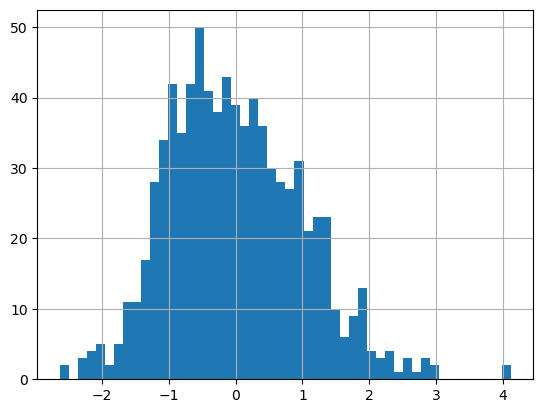

In [42]:
test = X_train[X_train['date'] == 0][num_cols]

test.apply(zscore)['0'].hist(bins=50)

<Axes: >

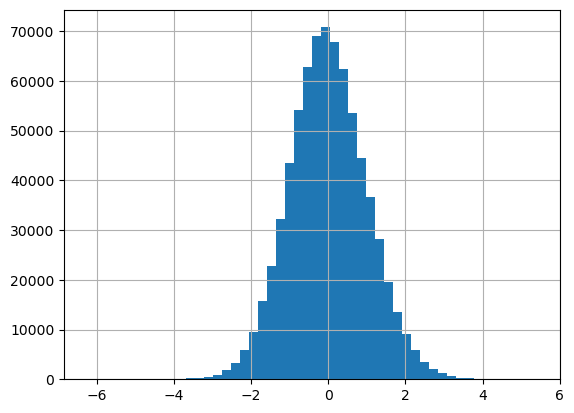

In [38]:
X_train['0'].hist(bins=50)